In [1]:
import pandas as pd
import numpy as np 
from pandas import ExcelWriter
%matplotlib inline
from datetime import datetime 
import time 

In [2]:
google_trends_overlap_df = pd.read_csv('C:/Users/Shoya/surf/data/GoogleTrends_for_multiple_keywords.csv', encoding='latin1')

keywords = google_trends_overlap_df.columns
keywords = keywords[1:]

google_trends_overlap_df["date"] = pd.to_datetime(google_trends_overlap_df["date"])
google_trends_overlap_df['Date_UTC_trend'] = google_trends_overlap_df['date'].dt.tz_localize('EST').dt.tz_convert('UTC')
#google_trends_overlap_df["Timestamp"] = [time.mktime(t.timetuple()) for t in google_trends_overlap_df.Date_UTC_trend]
google_trends_overlap_df["Timestamp"] = google_trends_overlap_df['Date_UTC_trend'].astype(np.int64)// 10**9

print(keywords)
google_trends_overlap_df.head(3)

Index(['Bitstamp', 'Coinbase', 'Ethereum', 'Bubble', 'Cryptocurrency',
       'Hashing', 'Blockchain'],
      dtype='object')


,date,Bitstamp,Coinbase,Ethereum,Bubble,Cryptocurrency,Hashing,Blockchain,Date_UTC_trend,Timestamp
0,2015-01-06 00:00:00,17,67,89,92,36,59,75,2015-01-06 05:00:00+00:00,1420520400
1,2015-01-06 01:00:00,13,69,91,96,22,51,72,2015-01-06 06:00:00+00:00,1420524000
2,2015-01-06 02:00:00,12,67,82,92,27,44,66,2015-01-06 07:00:00+00:00,1420527600


In [3]:
def weigh_using_overlap(row, overlap_df, duplicate_df, ratios, keyword):
    if ( (row['Timestamp'] < duplicate_df['Timestamp'].iloc[0])): #or (row['Timestamp'] > duplicate_df['Timestamp'].iloc[-1])): 
        # edge case for first week
        return row[keyword]
    else:
        try: 
            row_index = int(row.name) 
            if (row['Timestamp'] == overlap_df['Timestamp'].loc[row_index+1] ):
                # first occurence of the duplicate     
                duplicate_truncated_df = duplicate_df[duplicate_df['Timestamp'] <= row['Timestamp'] - 3600 ]
                if (len(duplicate_truncated_df) == 0 ): 
                    # very first duplicate, return as is 
                    #print('very first duplicate')
                    return row[keyword]
            else:
                duplicate_truncated_df = duplicate_df[duplicate_df['Timestamp'] <= row['Timestamp']]
            ratio = float(duplicate_truncated_df.iloc[-2][keyword]) / float(duplicate_truncated_df.iloc[-1][keyword])
            if (len(ratios) == 0):
                # first row 
                ratios.append(ratio)
            if ( len( duplicate_truncated_df) < 2 ):
                # first week edge case
                #print('first week')
                return row[keyword] 
            if ( (row['Timestamp'] == duplicate_truncated_df.iloc[-1]['Timestamp']) and (ratio != ratios[-1])  ):
                # ratio just changed 
                ratios.append(ratio*ratios[-1])
                #print('previous ratio: ', ratios[-2])
                #print('result ratio: ', ratios[-1] )
                return row[keyword] * ratios[-1]
            else:
                #print('using ratio: ', ratios[-1] )
                return row[keyword] * ratios[-1]
        except Exception as e:
            #display(e)
            
            # TODO: Address the problem of rows with value of 0
            
            return None
        
occurence_duplicates = google_trends_overlap_df[google_trends_overlap_df.duplicated(['Timestamp'], keep=False)]

for keyword in keywords:
    ratios = []
    google_trends_overlap_df[keyword] = google_trends_overlap_df.apply(lambda row: weigh_using_overlap(row, google_trends_overlap_df, occurence_duplicates, ratios, keyword), axis=1)    
    google_trends_overlap_df = google_trends_overlap_df.rename(columns = {keyword: keyword+'Trend'})

google_trends_overlap_df.drop_duplicates(subset='date',keep='last',inplace=True)
display(google_trends_overlap_df.head(100))

,date,BitstampTrend,CoinbaseTrend,EthereumTrend,BubbleTrend,CryptocurrencyTrend,HashingTrend,BlockchainTrend,Date_UTC_trend,Timestamp
0,2015-01-06 00:00:00,17.0,67.0,89.0,92.0,36.0,59.0,75.0,2015-01-06 05:00:00+00:00,1420520400
1,2015-01-06 01:00:00,13.0,69.0,91.0,96.0,22.0,51.0,72.0,2015-01-06 06:00:00+00:00,1420524000
2,2015-01-06 02:00:00,12.0,67.0,82.0,92.0,27.0,44.0,66.0,2015-01-06 07:00:00+00:00,1420527600
3,2015-01-06 03:00:00,11.0,48.0,66.0,86.0,36.0,44.0,67.0,2015-01-06 08:00:00+00:00,1420531200
4,2015-01-06 04:00:00,14.0,55.0,94.0,87.0,28.0,40.0,73.0,2015-01-06 09:00:00+00:00,1420534800
5,2015-01-06 05:00:00,13.0,52.0,61.0,77.0,24.0,81.0,64.0,2015-01-06 10:00:00+00:00,1420538400
6,2015-01-06 06:00:00,15.0,58.0,55.0,74.0,29.0,82.0,75.0,2015-01-06 11:00:00+00:00,1420542000
7,2015-01-06 07:00:00,20.0,58.0,31.0,67.0,23.0,61.0,64.0,2015-01-06 12:00:00+00:00,1420545600
8,2015-01-06 08:00:00,23.0,37.0,39.0,70.0,19.0,94.0,61.0,2015-01-06 13:00:00+00:00,1420549200
9,2015-01-06 09:00:00,22.0,31.0,53.0,63.0,14.0,69.0,62.0,2015-01-06 14:00:00+00:00,1420552800


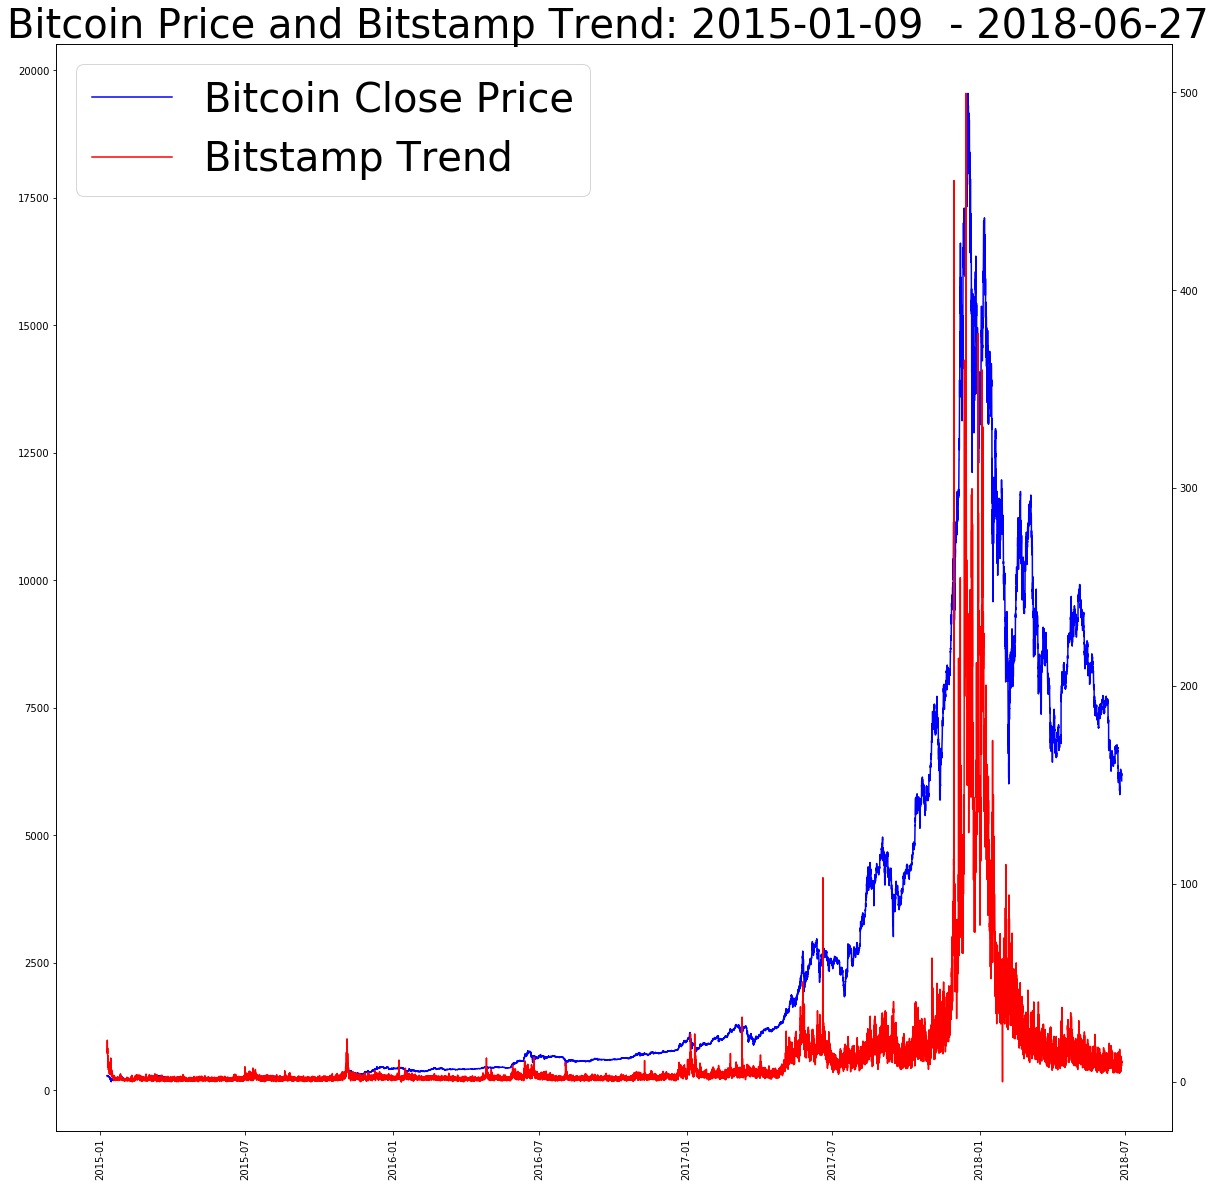

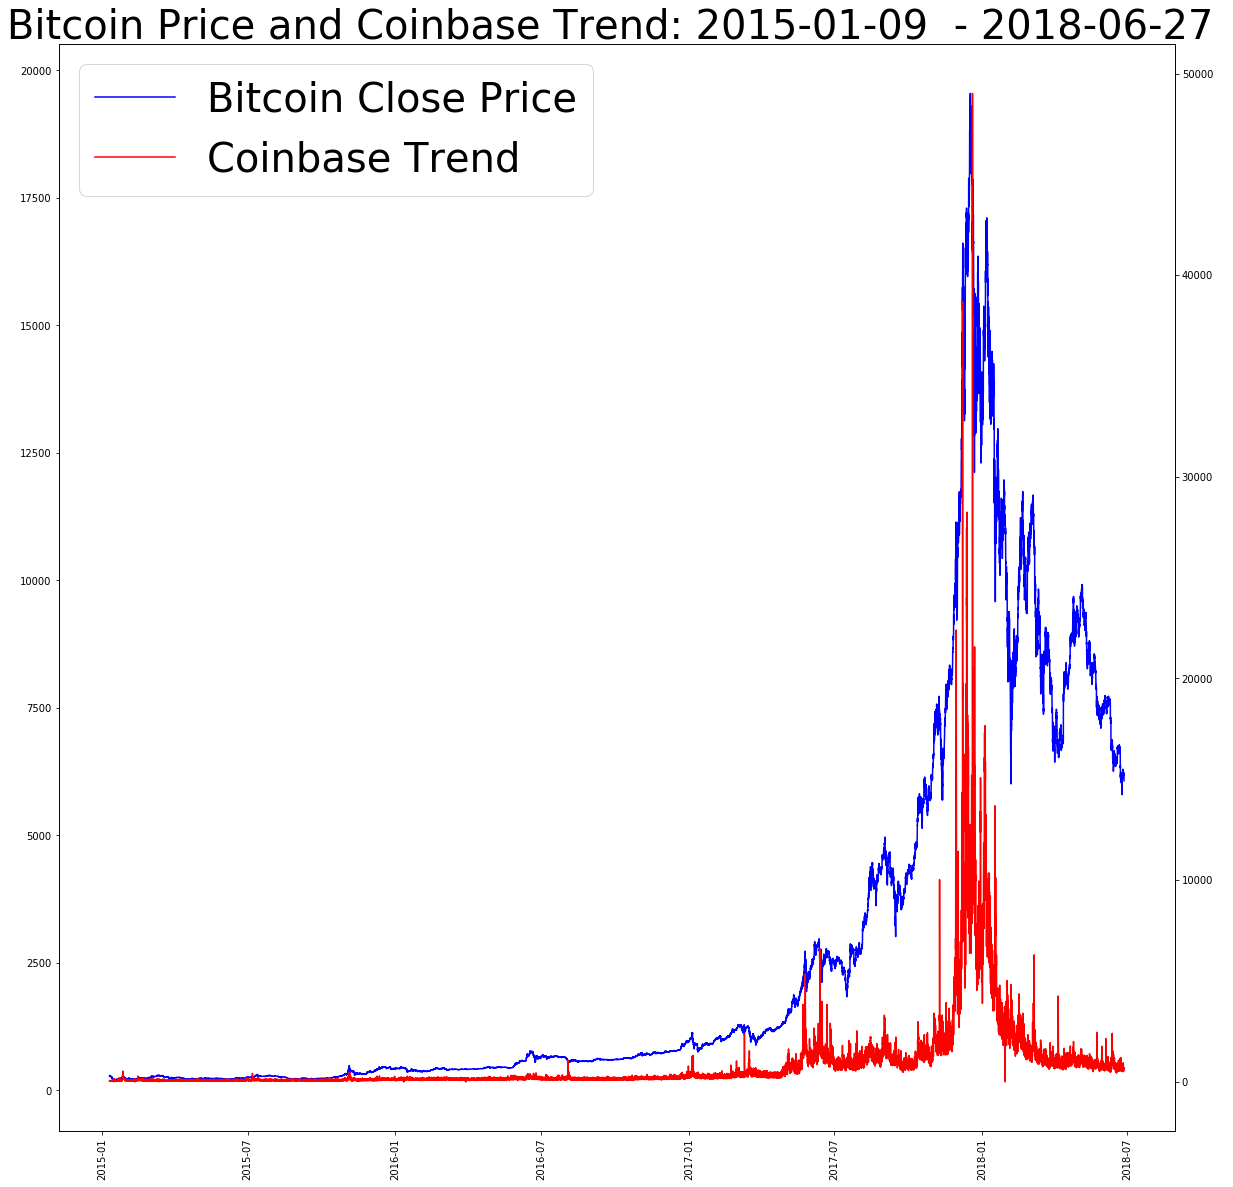

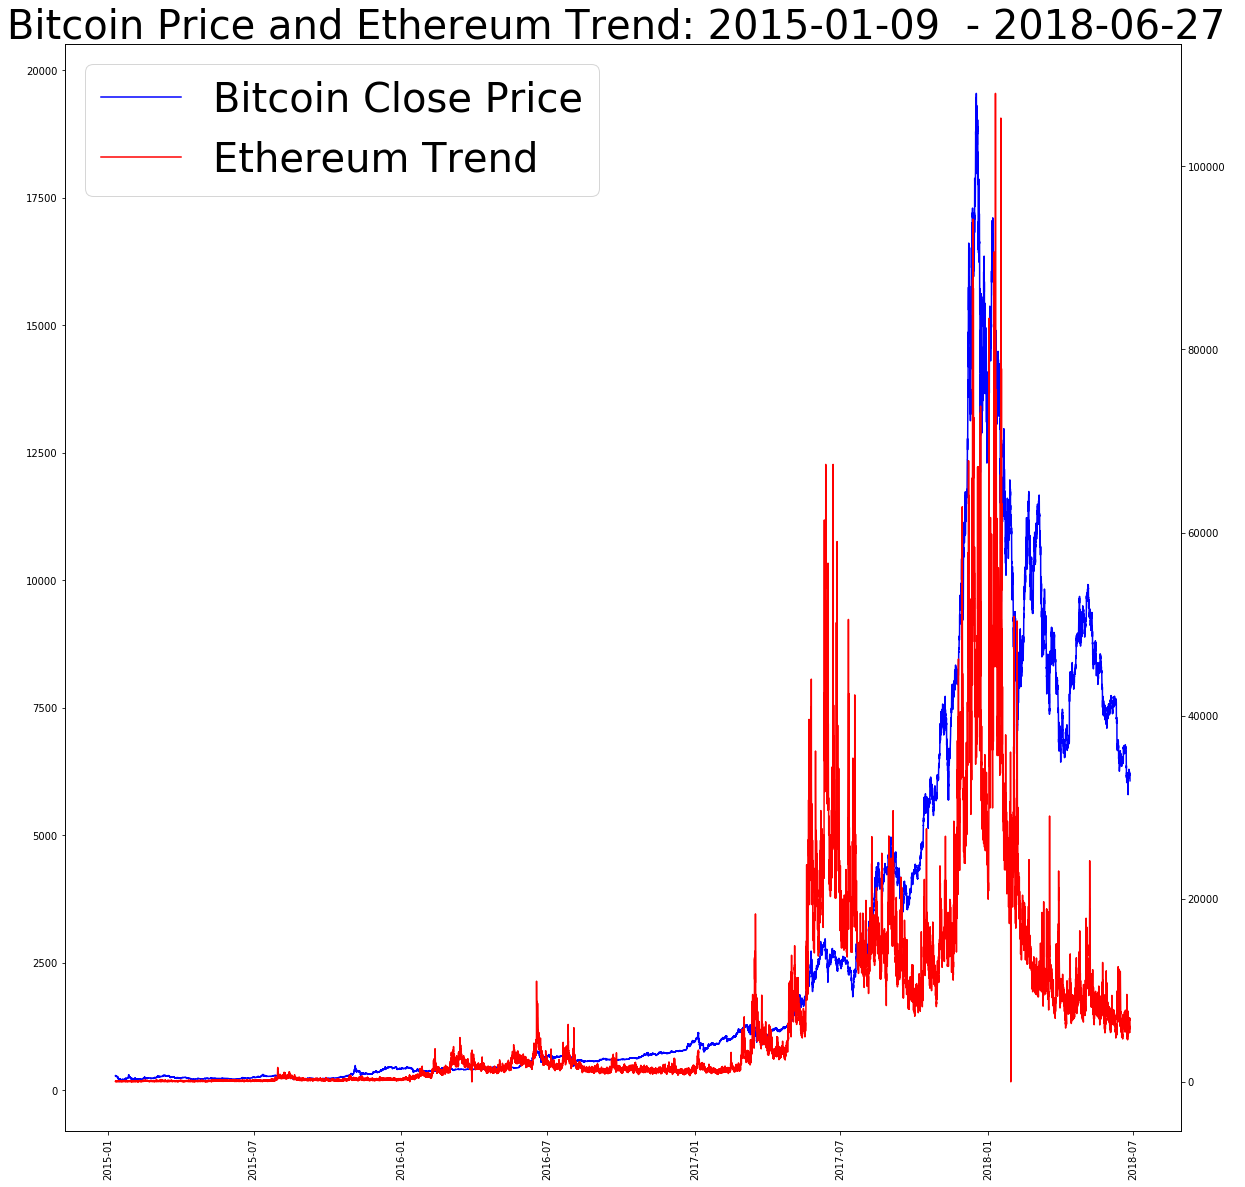

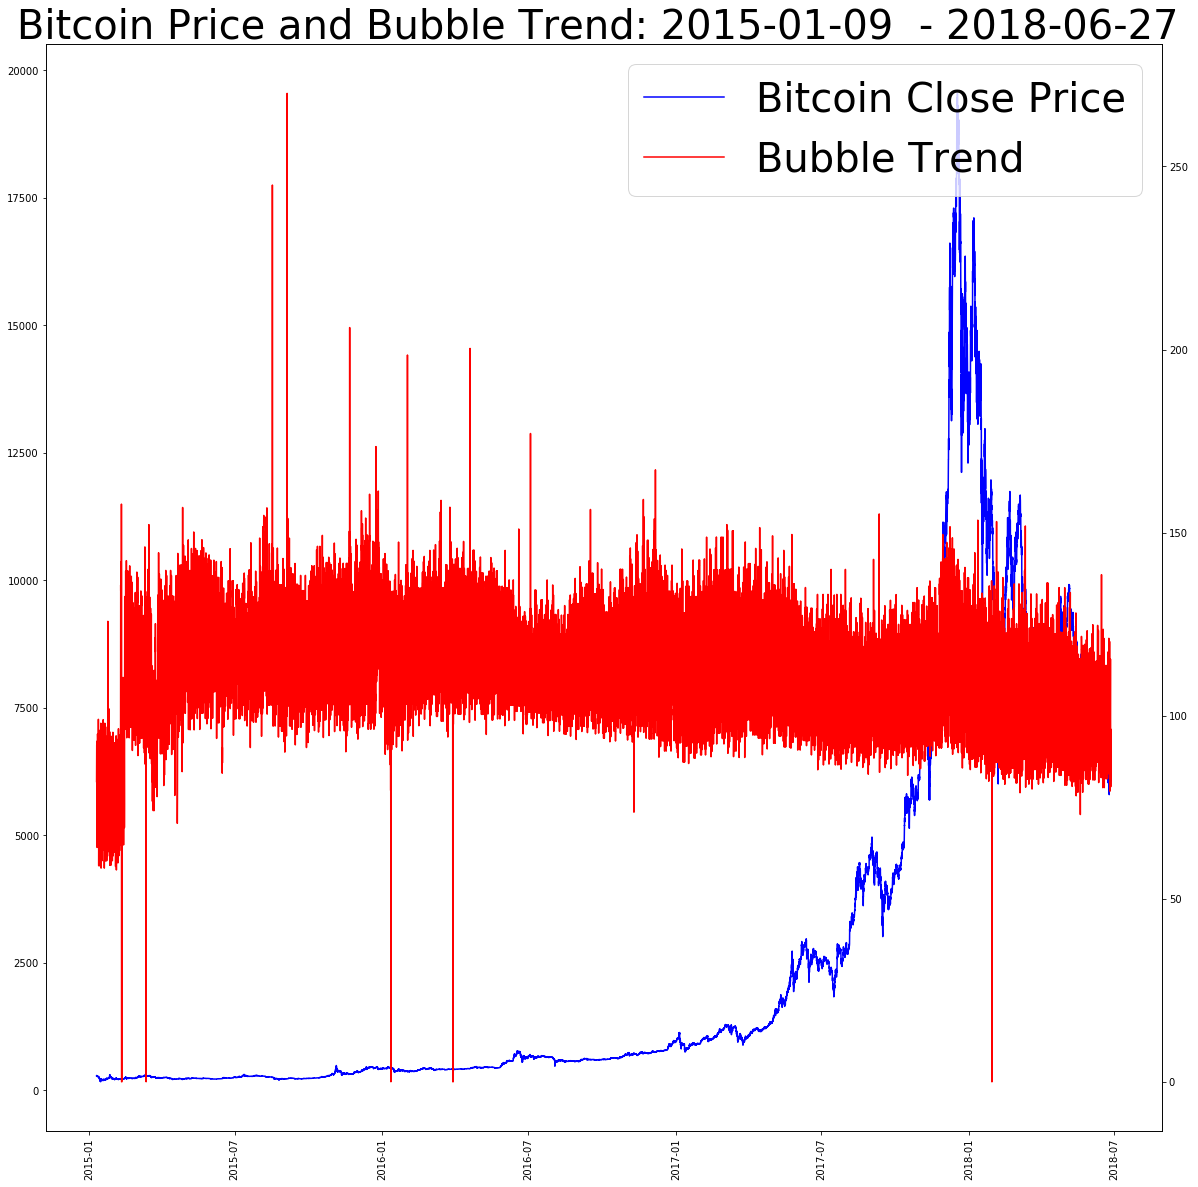

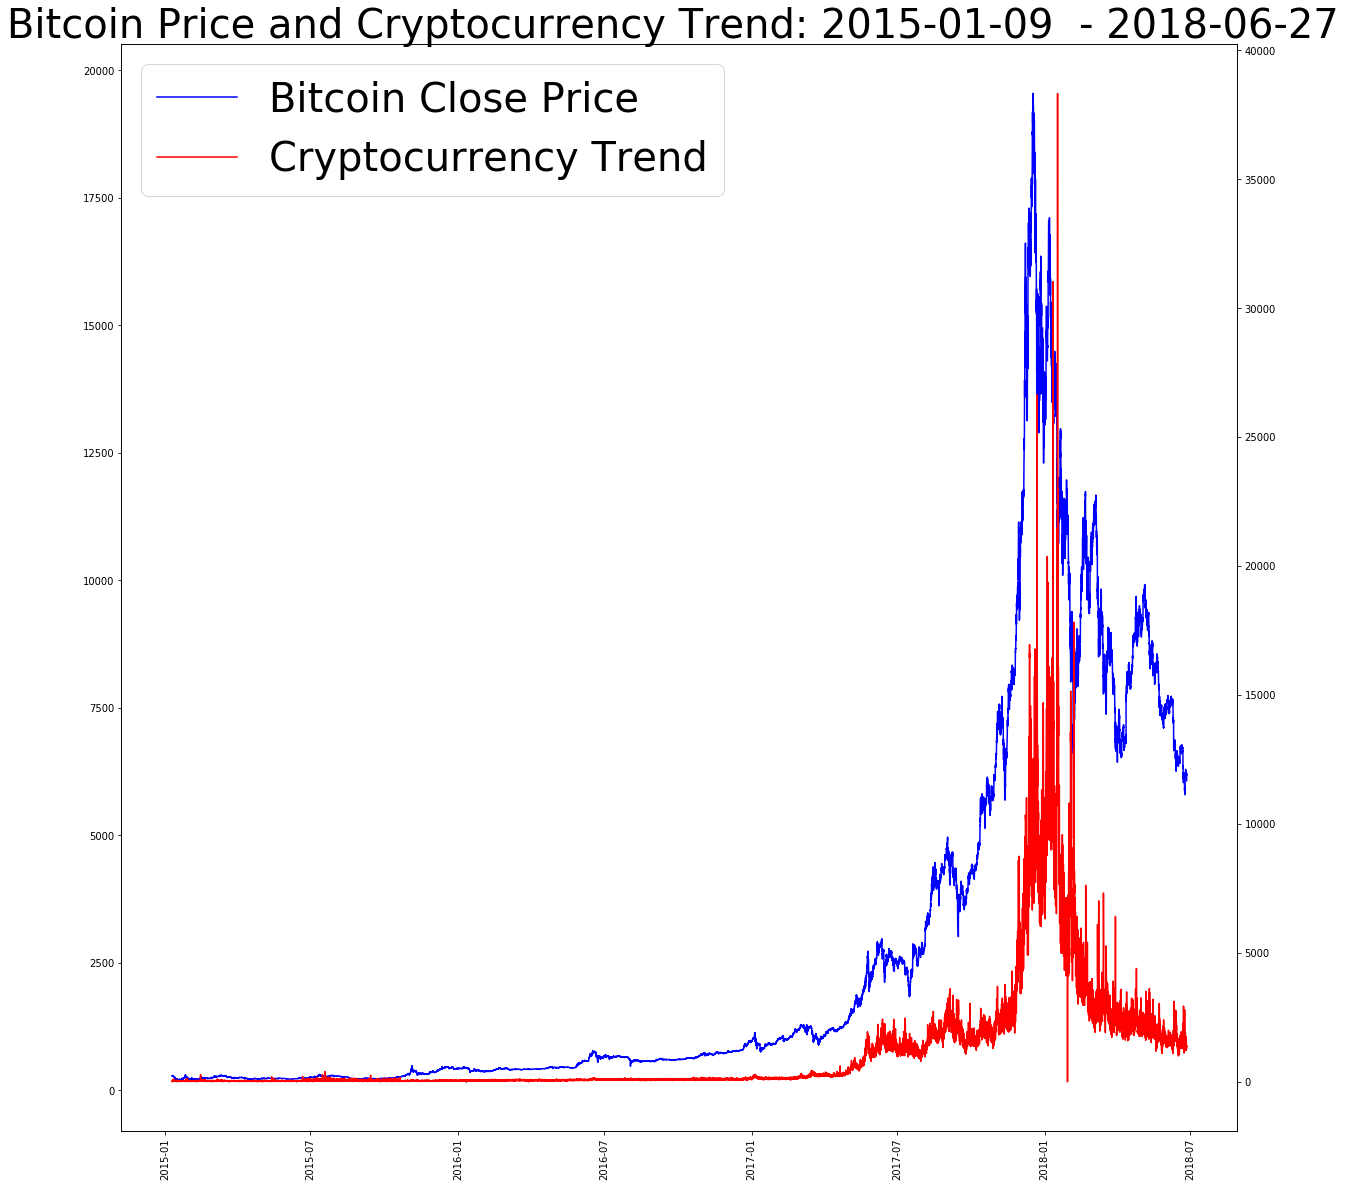

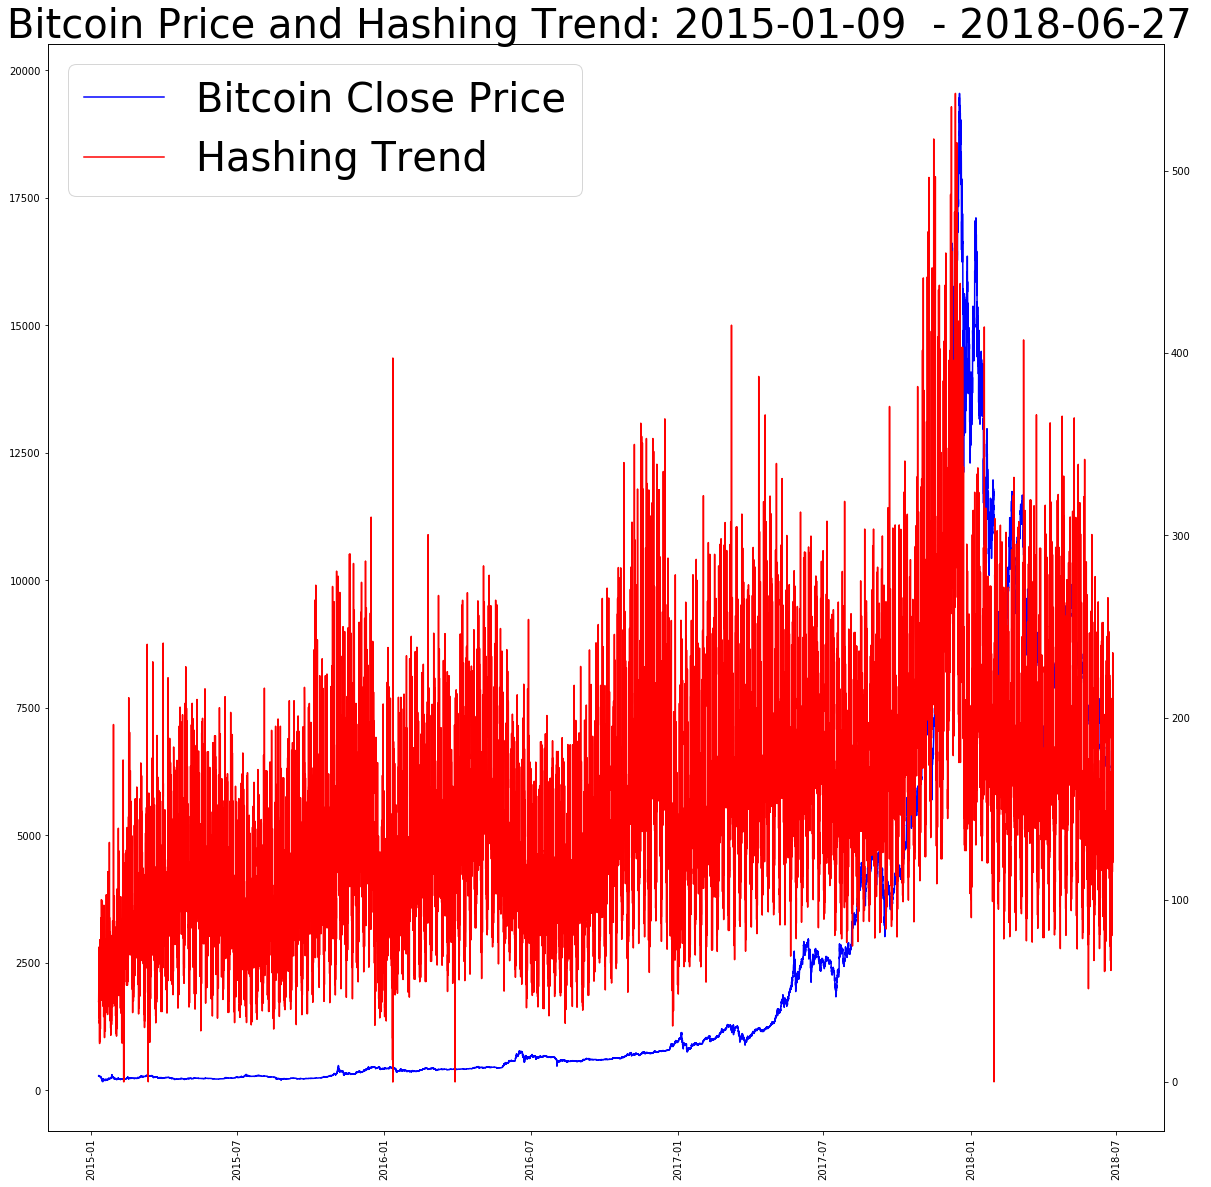

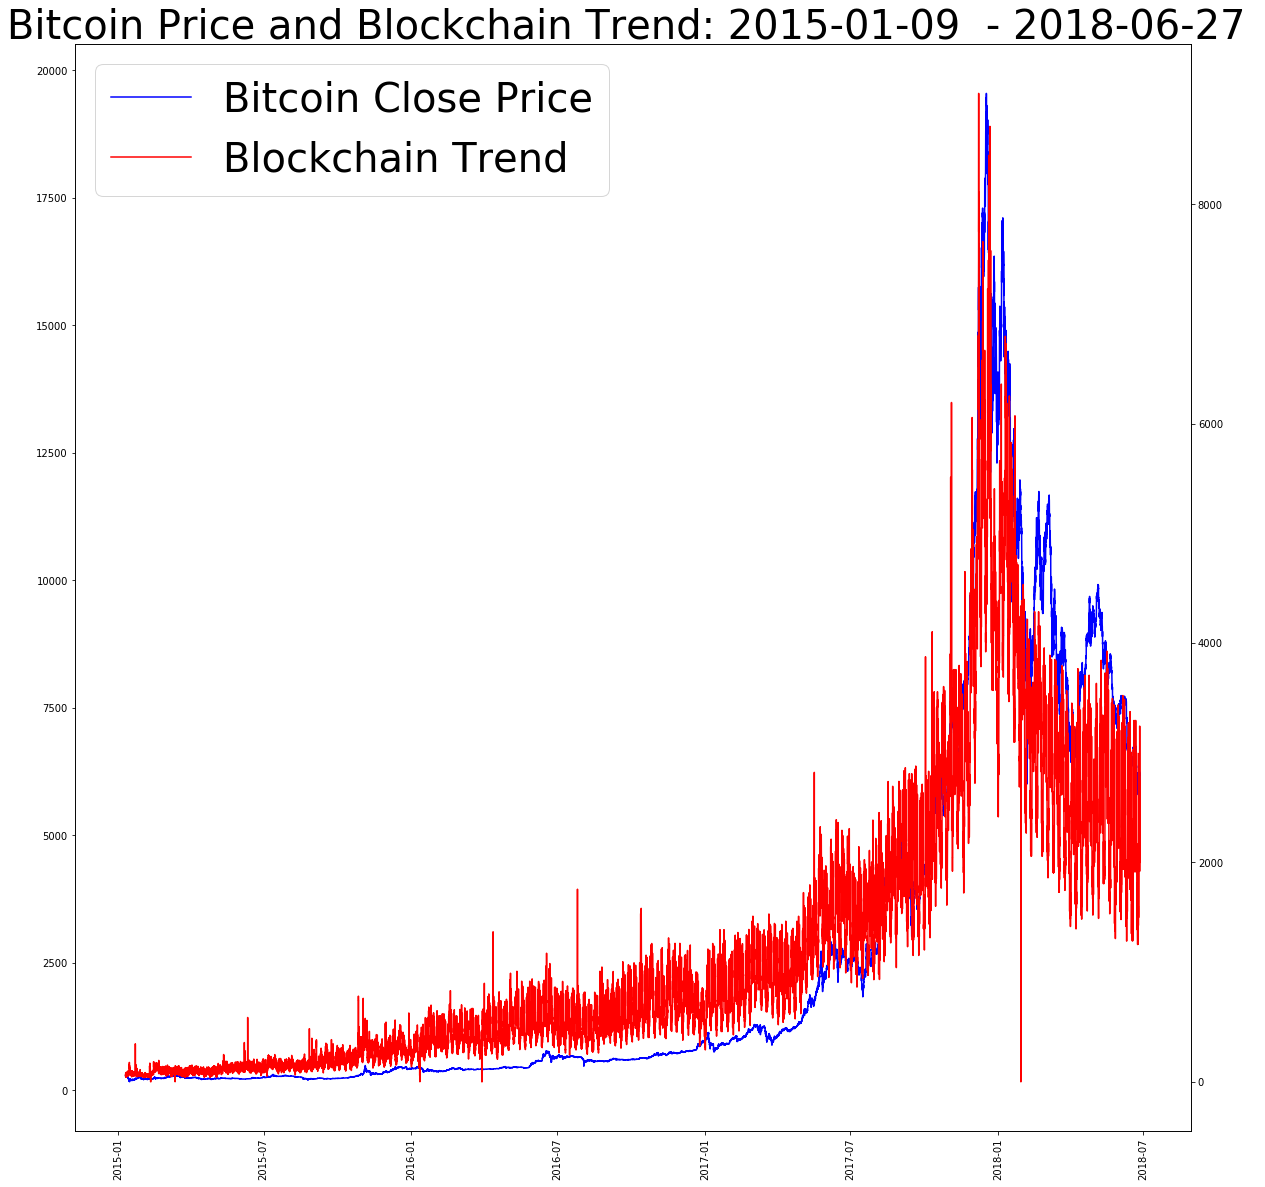

In [5]:
import matplotlib.pyplot as plt

btc_df = pd.read_csv('../data/BTC/BTC_2012_2018_06_1min.csv')
btc_df["Date(UTC)"] = pd.to_datetime(btc_df["Timestamp"], utc=True,unit='s')

btc_and_trends_df_hourly_overlap = pd.merge(left=btc_df, left_on="Timestamp", right=google_trends_overlap_df, right_on="Timestamp")


for keyword in keywords: 
    fig, ax = plt.subplots(figsize=(20,20))
    l1, = ax.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap["Close"], 'blue')
    ax2 = ax.twinx()
    l2, = ax2.plot(btc_and_trends_df_hourly_overlap["Date(UTC)"], btc_and_trends_df_hourly_overlap[keyword + 'Trend'], 'red')
    ax.set_title('Bitcoin Price and ' + keyword + ' Trend: ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[0])[:-8] + ' - ' + str(btc_and_trends_df_hourly_overlap["Date(UTC)"].iloc[-1])[:-8], fontsize=40 )
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.legend([l1, l2],["Bitcoin Close Price", keyword + ' Trend' ],fontsize=40)
    plt.show();


In [7]:
cols = [keyword + 'Trend' for keyword in keywords]
cols.append("Date_UTC_trend")
cols.append("Timestamp")


writer = pd.ExcelWriter("Adj_Google_Trends_for_Mult_Keywords.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
df = btc_and_trends_df_hourly_overlap[cols]
df.to_excel(writer)
writer.save()